# Dyna Q

We will be using **Dyna Q** on Cliff World environment as given below:  

![GridWorld](./images/cliffworld.png "Cliff World")


### Q Learning Update equation

Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. The Update equation is given below:

$$ 
\DeclareMathOperator*{\max}{max} Q(S,A) \leftarrow Q(S,A) + \alpha \cdot [ R + \gamma \cdot \max_{A'} Q(S’,A’) – Q(S,A)] $$



#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..


#### Imports

In [1]:
# Initial imports and environment setup
import numpy as np
import sys
import random
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode

from IPython.display import HTML
%matplotlib inline

2024-02-01 13:21:49.900642: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 13:21:49.948671: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 13:21:50.221261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 13:21:50.221706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 13:21:50.222760: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Q- Learning agent class
from collections import defaultdict

class DynaQAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions, n):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n = n
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.buffer = {}

    def get_Q(self, state, action):
        return self._Q[state][action]
        
    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step    
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + self.gamma * self.get_Q(next_state, best_next_action) - self.get_Q(state,action)
        else:
            td_error = reward - self.get_Q(state,action)
            
        new_value = self.get_Q(state,action) + self.alpha * td_error        
        self.set_Q(state, action, new_value)
            
    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        
        for action in actions:
            q_s_a = self.get_Q(state, action) 
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))
        
    # choose action as per ε-greedy policy for exploration
    def get_action(self, state):        
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [3]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [4]:
#training algorithm
def train_agent(env, agent, episode_cnt = 10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state,_ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            agent.update(state, action, reward, next_state, done)
            G += reward 
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the 
                # training period. 
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            # add the experience to agent’s buffer (i.e. agent’s model estimate)
            agent.buffer[(state,action)] = (next_state, reward, done)
            state = next_state
            # plan n steps through simulated experience
            for j in range(agent.n):
                state_v, action_v = random.choice(list(agent.buffer))
                next_state_v, reward_v, done_v = agent.buffer[(state_v,action_v)]
                agent.update(state_v, action_v, reward_v, next_state_v, done_v)
                
    return np.array(episode_rewards)

In [5]:
# helper function to print policy for Cliff world
def print_policy(env, agent):
    nR, nC = env._cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if env._cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()



In [6]:
# create cliff world environment
env = gym.make("CliffWalking-v0")
print(env.unwrapped.__doc__)


    Cliff walking involves crossing a gridworld from start to goal while avoiding falling off a cliff.

    ## Description
    The game starts with the player at location [3, 0] of the 4x12 grid world with the
    goal located at [3, 11]. If the player reaches the goal the episode ends.

    A cliff runs along [3, 1..10]. If the player moves to a cliff location it
    returns to the start location.

    The player makes moves until they reach the goal.

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto [<a href="#cliffwalk_ref">1</a>].

    With inspiration from:
    [https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py)

    ## Action Space
    The action shape is `(1,)` in the range `{0, 3}` indicating
    which direction to move the player.

    - 0: Move up
    - 1: Move right
    - 2: Move down

In [7]:
# create a Dyna-Q Learning agent
agent = DynaQAgent(alpha=0.25, epsilon=0.2, gamma=0.99, get_possible_actions=lambda s : range(env.nA), n=20)

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 500)

/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


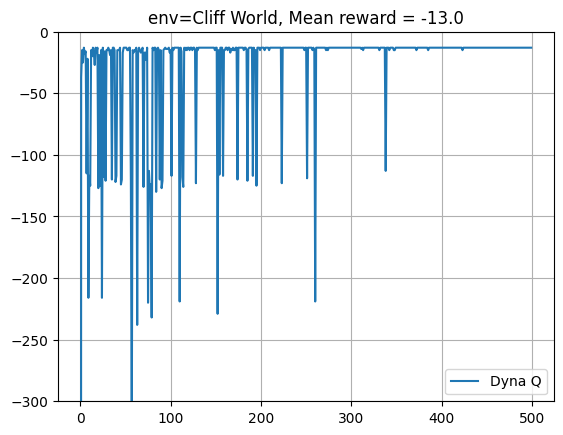

In [8]:
# Plot rewards
plot_rewards("Cliff World",rewards, 'Dyna Q')

In [9]:
# print policy 
print_policy(env.unwrapped, agent)

 >  v  >  v  >  >  v  v  v  v  >  v 
 >  >  >  v  >  >  >  v  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [10]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action = agent.get_action(obs[0])
        obs, _, _, _ = vec_env.step([action])
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)


In [11]:
video_folder = "logs/10_a/"
env_name= "CliffWalking-v0"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-CliffWalking-v0-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-CliffWalking-v0-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-CliffWalking-v0-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-CliffWalking-v0-step-0-to-step-500.mp4


/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


### Dyna Q Learning for "Taxi" environment 

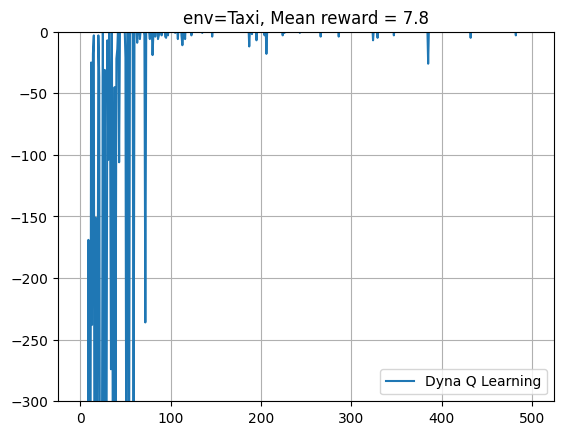

In [12]:
# create taxi environment
env = gym.make("Taxi-v3")

# create a Q Learning agent
agent = DynaQAgent(alpha=0.25, epsilon=0.2, gamma=0.99, get_possible_actions=lambda s : range(env.action_space.n), n=50)

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 500)

#plot reward graph
plot_rewards("Taxi", rewards, 'Dyna Q Learning')

In [13]:
video_folder = "logs/10_a/"
env_name= "Taxi-v3"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-Taxi-v3-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-Taxi-v3-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-Taxi-v3-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter10/logs/10_a/DynaQAgent-Taxi-v3-step-0-to-step-500.mp4


### Conclusion

We see that Dyna Q Agent learns the optimal policy faster as compared to Q-learning. As the learnt policy does not have any exploration, the agent learns the shortest route of walking across the maze, right on the row just above cliff. As the actions are deterministic and there is no exploration, the agent has no chance of falling into cliff when it takes a RIGHT action in a cell next to the cliff. Therefore, it learns to take the shortest route towards goal.

For Taxi environment with n-50, we can see that Dyna Q learns the optimal policy by 1-- episodes which is much faster than what we saw in vanilla Q-Learning. 